<a href="https://colab.research.google.com/github/CAllans-Git/Air-Quality-IoT-Project/blob/main/IoT_Project_Air_Quality_Update_Code_Final_update_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


Data Cleaning and Preparation

In [ ]:

# Load the dataset
data = pd.read_csv('city_day.csv')

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Feature Engineering: Extract year, month, and day from the date
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Calculate the percentage of missing values for each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Sort the missing values percentage in descending order
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# Remove columns with more than 50% missing values
columns_to_drop = missing_percentage_sorted[missing_percentage_sorted > 50].index
data.drop(columns=columns_to_drop, inplace=True)

# Impute missing values for numeric columns with less than 50% missing using median
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    if data[column].isnull().sum() > 0:
        data[column].fillna(data[column].median(), inplace=True)

# Assuming 'AQI_Bucket' is a non-numeric column and we want to impute it differently
if 'AQI_Bucket' in data.columns:
    data['AQI_Bucket'].fillna(data['AQI_Bucket'].mode()[0], inplace=True)

# Normalize the dataset (example: normalizing the 'NO' column)
# Assuming 'NO' is a numeric column that we want to normalize
if 'NO' in numeric_columns:
    scaler = MinMaxScaler()
    data['NO'] = scaler.fit_transform(data[['NO']])

# Split the data into training and testing sets
# Assuming 'AQI' is the target variable and we want to exclude 'Date' and 'AQI_Bucket' from features
X = data.drop(['AQI', 'AQI_Bucket', 'Date'], axis=1)
y = data['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The cleaned and prepared dataset is now in X_train, X_test, y_train, y_test


#Modeling
## Each model is evaluated separaely and a summary table of all model performances is provided at the end of this section

# Model 1: Deep Learning for AQI Bucket Classification
# Building a neural network for classification

In [ ]:
# Encode AQI_Bucket as numerical categories
label_encoder = LabelEncoder()
data['AQI_Bucket_Cat'] = label_encoder.fit_transform(data['AQI_Bucket'])

# Prepare features and labels
X = data.drop(['City', 'Date', 'AQI_Bucket', 'AQI_Bucket_Cat', 'AQI'], axis=1)
y = to_categorical(data['AQI_Bucket_Cat'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model building: Deep Learning for AQI Classification

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

# Evaluate the model
scores = model.evaluate(X_test, y_test)
print(f"Accuracy: {scores[1]*100}")


Epoch 1/100
2363/2363 [==============================] - 9s 3ms/step - loss: 3.8541 - accuracy: 0.5617 - val_loss: 2.3319 - val_accuracy: 0.6939
Epoch 2/100
2363/2363 [==============================] - 7s 3ms/step - loss: 2.2373 - accuracy: 0.6100 - val_loss: 1.5863 - val_accuracy: 0.5688
Epoch 3/100
2363/2363 [==============================] - 7s 3ms/step - loss: 1.6566 - accuracy: 0.6280 - val_loss: 1.0544 - val_accuracy: 0.6745
Epoch 4/100
2363/2363 [==============================] - 7s 3ms/step - loss: 1.2484 - accuracy: 0.6476 - val_loss: 0.8829 - val_accuracy: 0.7241
Epoch 5/100
2363/2363 [==============================] - 7s 3ms/step - loss: 0.9301 - accuracy: 0.6676 - val_loss: 0.9627 - val_accuracy: 0.5966
Epoch 6/100
2363/2363 [==============================] - 7s 3ms/step - loss: 0.8119 - accuracy: 0.6885 - val_loss: 0.8346 - val_accuracy: 0.6201
Epoch 7/100
2363/2363 [==============================] - 7s 3ms/step - loss: 0.7246 - accuracy: 0.7113 - val_loss: 0.6826 - val_ac

In [ ]:
# Evaluate the model
scores = model.evaluate(X_test, y_test)
print(f"Accuracy: {scores[1] * 100}")


185/185 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.7806
Accuracy: 78.0599296092987


In [ ]:
# Evaluation
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Model checkpointing to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Model architecture
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with callbacks
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10, callbacks=[early_stopping, model_checkpoint])

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model
scores = model.evaluate(X_test, y_test)
print(f"Accuracy: {scores[1]*100}")

# Additional performance metrics
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_test.argmax(axis=-1)

print(classification_report(y_true_classes, y_pred_classes))
print(confusion_matrix(y_true_classes, y_pred_classes))


Epoch 1/100
2353/2363 [============================>.] - ETA: 0s - loss: 5.0569 - accuracy: 0.5383
Epoch 1: val_loss improved from inf to 2.30369, saving model to best_model.h5
2363/2363 [==============================] - 8s 3ms/step - loss: 5.0445 - accuracy: 0.5391 - val_loss: 2.3037 - val_accuracy: 0.5637
Epoch 2/100
  61/2363 [..............................] - ETA: 5s - loss: 2.8666 - accuracy: 0.5705

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2345/2363 [============================>.] - ETA: 0s - loss: 2.5805 - accuracy: 0.5994
Epoch 2: val_loss did not improve from 2.30369
2363/2363 [==============================] - 7s 3ms/step - loss: 2.5850 - accuracy: 0.5992 - val_loss: 3.4657 - val_accuracy: 0.6836
Epoch 3/100
2352/2363 [============================>.] - ETA: 0s - loss: 1.9570 - accuracy: 0.6214
Epoch 3: val_loss improved from 2.30369 to 1.05725, saving model to best_model.h5
2363/2363 [==============================] - 7s 3ms/step - loss: 1.9544 - accuracy: 0.6216 - val_loss: 1.0572 - val_accuracy: 0.6929
Epoch 4/100
2362/2363 [============================>.] - ETA: 0s - loss: 1.3714 - accuracy: 0.6360
Epoch 4: val_loss improved from 1.05725 to 0.73220, saving model to best_model.h5
2363/2363 [==============================] - 7s 3ms/step - loss: 1.3713 - accuracy: 0.6360 - val_loss: 0.7322 - val_accuracy: 0.7300
Epoch 5/100
2352/2363 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.6794
Epoch 

# Model 2: LSTM for Time Series Forecasting


In [ ]:
# Preparing data for LSTM model To predict 'AQI' as the variable
aqi_values = data['AQI'].fillna(method='ffill').values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_aqi = scaler.fit_transform(aqi_values)

In [ ]:
n_input = 14  # Number of time steps to predict into the future
batch_size = 1  # Number of timeseries samples in each batch

# Create the TimeseriesGenerator for LSTM model
generator = TimeseriesGenerator(scaled_aqi, scaled_aqi, length=n_input, batch_size=batch_size)




In [ ]:
# Generate sequences for LSTM input
n_input = 14
generator = TimeseriesGenerator(scaled_aqi, scaled_aqi, length=n_input, batch_size=1)

# Building LSTM model
model2 = Sequential([
    LSTM(50, activation='relu', input_shape=(n_input, 1)),
    Dropout(0.2),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mean_squared_error')

# Fit the LSTM model
model2.fit(generator, epochs=10, steps_per_epoch=len(generator))

Epoch 1/10
29517/29517 [==============================] - 355s 12ms/step - loss: 0.0015
Epoch 2/10
29517/29517 [==============================] - 350s 12ms/step - loss: 0.0013
Epoch 3/10
29517/29517 [==============================] - 352s 12ms/step - loss: 0.0012
Epoch 4/10
29517/29517 [==============================] - 350s 12ms/step - loss: 0.0012
Epoch 5/10
29517/29517 [==============================] - 349s 12ms/step - loss: 0.0012
Epoch 6/10
29517/29517 [==============================] - 351s 12ms/step - loss: 0.0012
Epoch 7/10
29517/29517 [==============================] - 352s 12ms/step - loss: 0.0011
Epoch 8/10
29517/29517 [==============================] - 357s 12ms/step - loss: 0.0011
Epoch 9/10
29517/29517 [==============================] - 351s 12ms/step - loss: 0.0011
Epoch 10/10
29517/29517 [==============================] - 349s 12ms/step - loss: 0.0011


In [ ]:
# Evaluate the LSTM model
scores_2 = model2.evaluate(generator)
print("Model 2 - LSTM model")
print(f"Loss: {scores_2}")

29517/29517 [==============================] - 106s 4ms/step - loss: 9.7259e-04
Model 2 - LSTM model
Loss: 0.0009725869749672711


In [ ]:
# Evaluation

# DataFrame has a column 'AQI' for Air Quality Index values used for evaluation
aqi_values = data['AQI'].fillna(method='ffill').values.reshape(-1, 1)

# Scaling the AQI values to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_aqi = scaler.fit_transform(aqi_values)

# Preparing time series data for LSTM model
n_input = 14  # number of steps to predict into the future
batch_size = 1  # number of timeseries samples in each batch

# Creating the TimeseriesGenerator
generator = TimeseriesGenerator(scaled_aqi, scaled_aqi, length=n_input, batch_size=batch_size)

# Building the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_input, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model
model.fit(generator, epochs=10, steps_per_epoch=len(generator))


Epoch 1/10
29517/29517 [==============================] - 358s 12ms/step - loss: 0.0014
Epoch 2/10
29517/29517 [==============================] - 347s 12ms/step - loss: 0.0013
Epoch 3/10
29517/29517 [==============================] - 346s 12ms/step - loss: 0.0012
Epoch 4/10
29517/29517 [==============================] - 346s 12ms/step - loss: 0.0012
Epoch 5/10
29517/29517 [==============================] - 347s 12ms/step - loss: 0.0011
Epoch 6/10
29517/29517 [==============================] - 345s 12ms/step - loss: 0.0011
Epoch 7/10
29517/29517 [==============================] - 347s 12ms/step - loss: 0.0011
Epoch 8/10
29517/29517 [==============================] - 348s 12ms/step - loss: 0.0012
Epoch 9/10
29517/29517 [==============================] - 347s 12ms/step - loss: 0.0011
Epoch 10/10
29517/29517 [==============================] - 348s 12ms/step - loss: 0.0011


#Model 3: Custom CNN Architecture

In [ ]:
def build_custom_cnn_v4(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Reshaping X_train to have the shape (number of samples, number of features, 1)
X_train_reshaped = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))

# Building the modified model
model_cnn_v4 = build_custom_cnn_v4(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), num_classes=y_train.shape[1])
model_cnn_v4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the modified model
model_cnn_v4.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=120, batch_size=64)


Epoch 1/120
296/296 [==============================] - 6s 7ms/step - loss: 1.0763 - accuracy: 0.5813 - val_loss: 1.0430 - val_accuracy: 0.6091
Epoch 2/120
296/296 [==============================] - 1s 5ms/step - loss: 0.8340 - accuracy: 0.6749 - val_loss: 0.7983 - val_accuracy: 0.6544
Epoch 3/120
296/296 [==============================] - 2s 6ms/step - loss: 0.7835 - accuracy: 0.6969 - val_loss: 1.0954 - val_accuracy: 0.5670
Epoch 4/120
296/296 [==============================] - 2s 6ms/step - loss: 0.7543 - accuracy: 0.7032 - val_loss: 0.7029 - val_accuracy: 0.7403
Epoch 5/120
296/296 [==============================] - 2s 5ms/step - loss: 0.7279 - accuracy: 0.7121 - val_loss: 0.7380 - val_accuracy: 0.6974
Epoch 6/120
296/296 [==============================] - 1s 5ms/step - loss: 0.7088 - accuracy: 0.7177 - val_loss: 0.6610 - val_accuracy: 0.7352
Epoch 7/120
296/296 [==============================] - 2s 5ms/step - loss: 0.6984 - accuracy: 0.7269 - val_loss: 0.6456 - val_accuracy: 0.7520

185/185 - 0s - loss: 0.5692 - accuracy: 0.8087 - 368ms/epoch - 2ms/step
Test accuracy: 0.8087015151977539, Test loss: 0.5692265629768372
Epoch 1/120
296/296 [==============================] - 2s 5ms/step - loss: 0.4602 - accuracy: 0.8189 - val_loss: 0.6179 - val_accuracy: 0.8023
Epoch 2/120
296/296 [==============================] - 2s 5ms/step - loss: 0.4616 - accuracy: 0.8155 - val_loss: 0.5699 - val_accuracy: 0.8083
Epoch 3/120
296/296 [==============================] - 2s 5ms/step - loss: 0.4555 - accuracy: 0.8216 - val_loss: 0.6643 - val_accuracy: 0.7839
Epoch 4/120
296/296 [==============================] - 2s 5ms/step - loss: 0.4594 - accuracy: 0.8185 - val_loss: 0.5818 - val_accuracy: 0.8085
Epoch 5/120
296/296 [==============================] - 2s 5ms/step - loss: 0.4638 - accuracy: 0.8141 - val_loss: 0.5806 - val_accuracy: 0.8055
Epoch 6/120
296/296 [==============================] - 1s 5ms/step - loss: 0.4642 - accuracy: 0.8171 - val_loss: 0.5936 - val_accuracy: 0.8106
Epoch

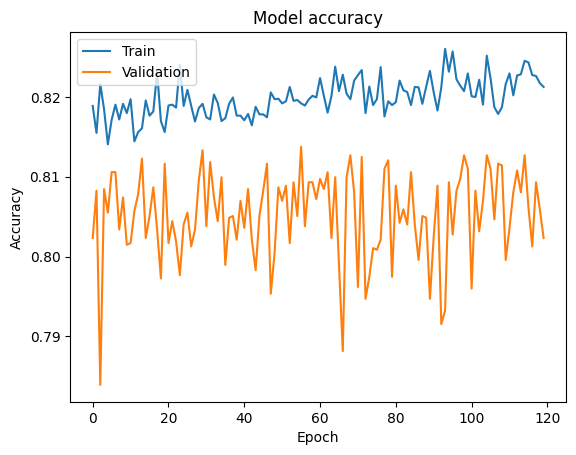

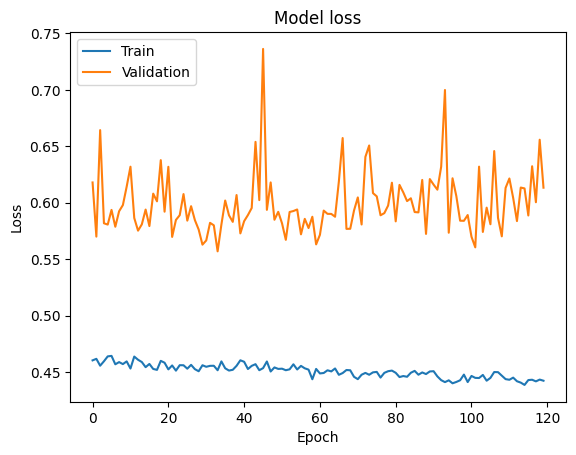

185/185 [==============================] - 0s 2ms/step


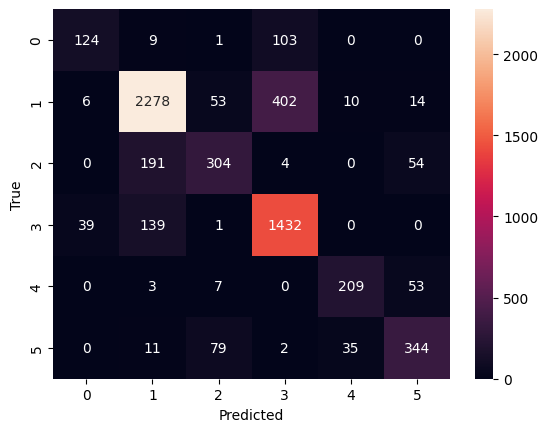

In [ ]:

# Getting X_test and y_test from test datasets
X_test_reshaped = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluate the model on the test data
test_loss, test_acc = model_cnn_v4.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

# Fit the model and keep the history
history = model_cnn_v4.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=120, batch_size=64)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predictions for the confusion matrix
predictions = model_cnn_v4.predict(X_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#Model 4: Custom LSTM Architecture

In [ ]:
# Define the custom LSTM model
def build_custom_lstm(input_shape, output_units):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))  # Set return_sequences=False
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(output_units))
    return model

# Target labels with 6 dimensions
output_units = 6

# Use Adam optimizer with a custom learning rate of 0.001
optimizer = Adam(learning_rate=0.001)

# Using the reshaped X_train to define the input shape
model_lstm = build_custom_lstm(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), output_units=output_units)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit the model on reshaped training data
model_lstm.fit(X_train_reshaped, y_train, epochs=120, batch_size=32, verbose=2)


Epoch 1/120
739/739 - 5s - loss: 0.2482 - 5s/epoch - 7ms/step
Epoch 2/120
739/739 - 3s - loss: 0.0870 - 3s/epoch - 4ms/step
Epoch 3/120
739/739 - 3s - loss: 0.0784 - 3s/epoch - 4ms/step
Epoch 4/120
739/739 - 3s - loss: 0.0749 - 3s/epoch - 4ms/step
Epoch 5/120
739/739 - 3s - loss: 0.0725 - 3s/epoch - 4ms/step
Epoch 6/120
739/739 - 3s - loss: 0.0702 - 3s/epoch - 4ms/step
Epoch 7/120
739/739 - 3s - loss: 0.0690 - 3s/epoch - 4ms/step
Epoch 8/120
739/739 - 3s - loss: 0.0680 - 3s/epoch - 4ms/step
Epoch 9/120
739/739 - 3s - loss: 0.0665 - 3s/epoch - 4ms/step
Epoch 10/120
739/739 - 3s - loss: 0.0655 - 3s/epoch - 4ms/step
Epoch 11/120
739/739 - 3s - loss: 0.0645 - 3s/epoch - 4ms/step
Epoch 12/120
739/739 - 3s - loss: 0.0630 - 3s/epoch - 4ms/step
Epoch 13/120
739/739 - 3s - loss: 0.0625 - 3s/epoch - 4ms/step
Epoch 14/120
739/739 - 3s - loss: 0.0618 - 3s/epoch - 4ms/step
Epoch 15/120
739/739 - 3s - loss: 0.0606 - 3s/epoch - 4ms/step
Epoch 16/120
739/739 - 3s - loss: 0.0598 - 3s/epoch - 4ms/step
E

In [ ]:
# Evaluation

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# Train the model with validation split
history = model_lstm.fit(X_train_reshaped, y_train, epochs=120, batch_size=32,
                         validation_split=0.2, verbose=2, callbacks=callbacks)

# Load the best model
model_lstm.load_weights('best_model.h5')

# Evaluate on test data
test_loss = model_lstm.evaluate(X_test_reshaped, y_test, verbose=2)

# Predictions
predictions = model_lstm.predict(X_test_reshaped)

# Calculate further metrics as per your problem
# For regression:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test MSE: {mse}, R^2 Score: {r2}")


Epoch 1/120

Epoch 1: val_loss improved from inf to 0.03207, saving model to best_model.h5
591/591 - 3s - loss: 0.0357 - val_loss: 0.0321 - 3s/epoch - 5ms/step
Epoch 2/120


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0357 - val_loss: 0.0328 - 2s/epoch - 4ms/step
Epoch 3/120

Epoch 3: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0359 - val_loss: 0.0326 - 2s/epoch - 4ms/step
Epoch 4/120

Epoch 4: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0352 - val_loss: 0.0325 - 2s/epoch - 4ms/step
Epoch 5/120

Epoch 5: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0355 - val_loss: 0.0331 - 2s/epoch - 4ms/step
Epoch 6/120

Epoch 6: val_loss did not improve from 0.03207
591/591 - 3s - loss: 0.0352 - val_loss: 0.0336 - 3s/epoch - 4ms/step
Epoch 7/120

Epoch 7: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0350 - val_loss: 0.0352 - 2s/epoch - 4ms/step
Epoch 8/120

Epoch 8: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0344 - val_loss: 0.0362 - 2s/epoch - 4ms/step
Epoch 9/120

Epoch 9: val_loss did not improve from 0.03207
591/591 - 2s - loss: 0.0349 - val_loss: 0.0352 - 

In [ ]:
# Print model summaries
print("Model 1 Summary:")
model.summary()
print("\nModel 2 Summary:")
model2.summary()
print("\nModel CNN v4 Summary:")
model_cnn_v4.summary()
print("\nModel LSTM Summary:")
model_lstm.summary()

Model 1 Summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model 2 Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                           

In [ ]:
# Model Comparison
# Create a DataFrame to store model performance metrics
model_metrics = pd.DataFrame({
    'Model': ['Deep Learning (AQI Bucket)', 'LSTM (AQI)', 'Custom CNN v4', 'Custom LSTM'],
    'Accuracy': [scores[1] * 100, scores_2, test_acc, r2],
    'MSE': [None, None, test_loss, mse]
})

# Sort the DataFrame by accuracy in descending order
model_metrics = model_metrics.sort_values(by='Accuracy', ascending=False)

# Display the DataFrame
print("Model Performance Summary:")
print(model_metrics.to_string())

# Print a ranking of the models based on accuracy
print("\nModel Ranking by Accuracy:")
for i, model in enumerate(model_metrics['Model']):
    print(f"{i+1}. {model}")


Model Performance Summary:
                        Model   Accuracy       MSE
0  Deep Learning (AQI Bucket)  76.146942       NaN
2               Custom CNN v4   0.808702  0.051765
3                 Custom LSTM   0.529029  0.051765
1                  LSTM (AQI)   0.000973       NaN

Model Ranking by Accuracy:
1. Deep Learning (AQI Bucket)
2. Custom CNN v4
3. Custom LSTM
4. LSTM (AQI)


#EDA

Summary Statistics:
               PM2.5          PM10            NO           NO2           NOx  \
count  29531.000000  29531.000000  29531.000000  29531.000000  29531.000000   
mean      64.510857    109.659366      0.042550     27.726576     31.063568   
std       59.807551     72.324020      0.055051     23.050531     29.477748   
min        0.040000      0.010000      0.000000      0.010000      0.000000   
25%       32.150000     79.315000      0.015845     12.980000     14.670000   
50%       48.570000     95.680000      0.025265     21.690000     23.520000   
75%       72.450000    111.880000      0.044924     34.665000     36.015000   
max      949.990000   1000.000000      1.000000    362.210000    467.630000   

                NH3            CO           SO2            O3       Benzene  \
count  29531.000000  29531.000000  29531.000000  29531.000000  29531.000000   
mean      20.813789      2.153872     13.830897     33.994121      2.859874   
std       21.028862      6.724

<ipython-input-42-8b97a521ea47>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".2f")


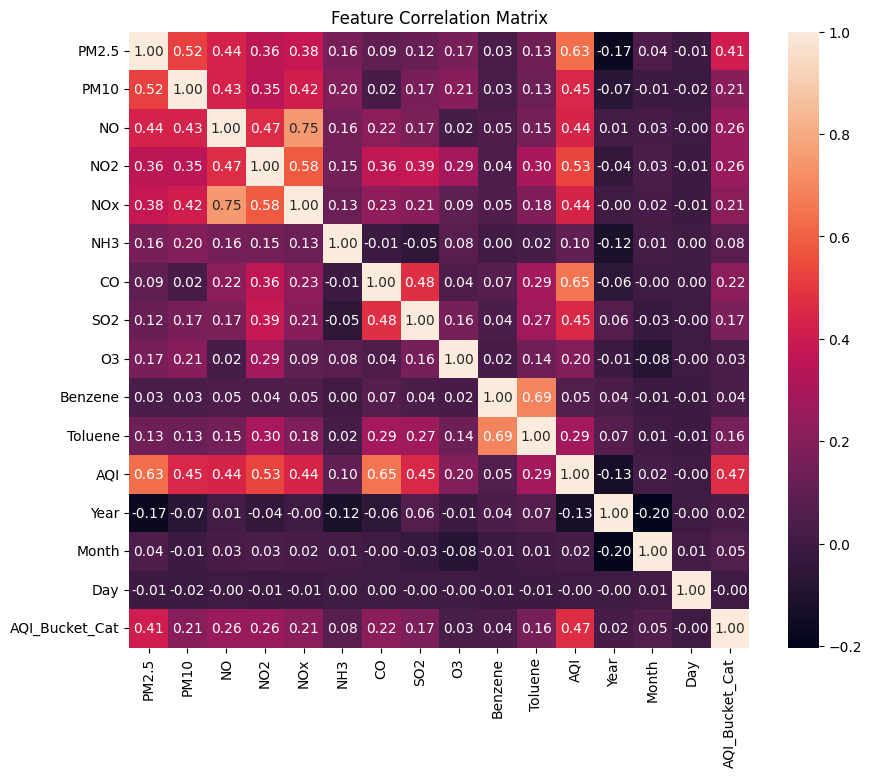

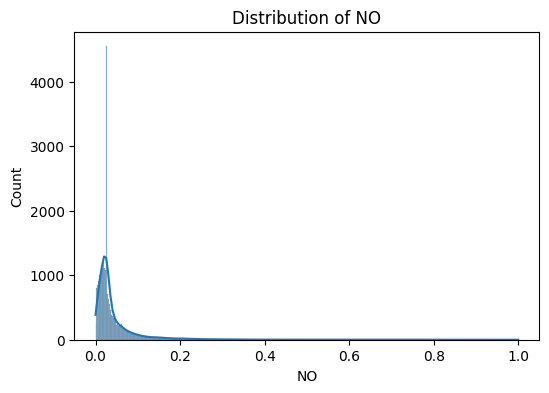

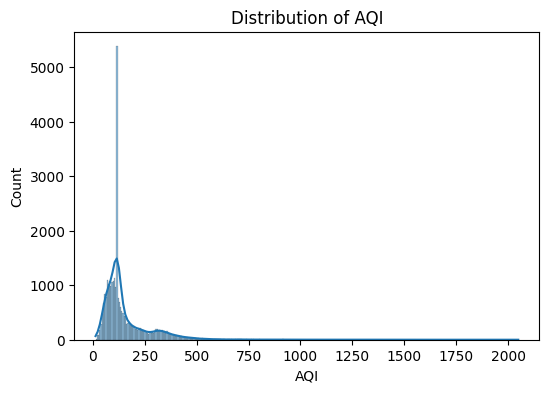

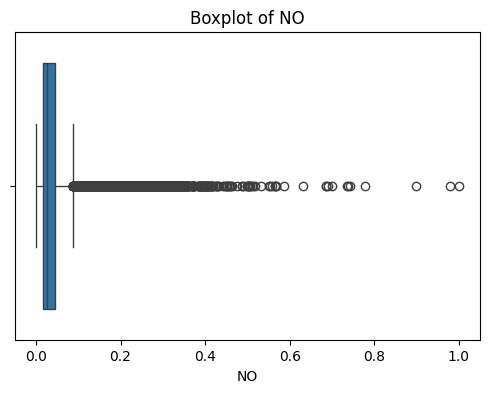

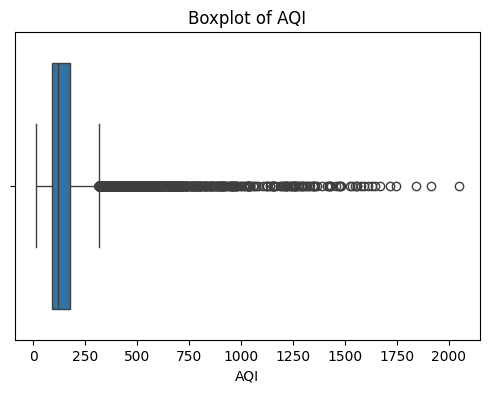

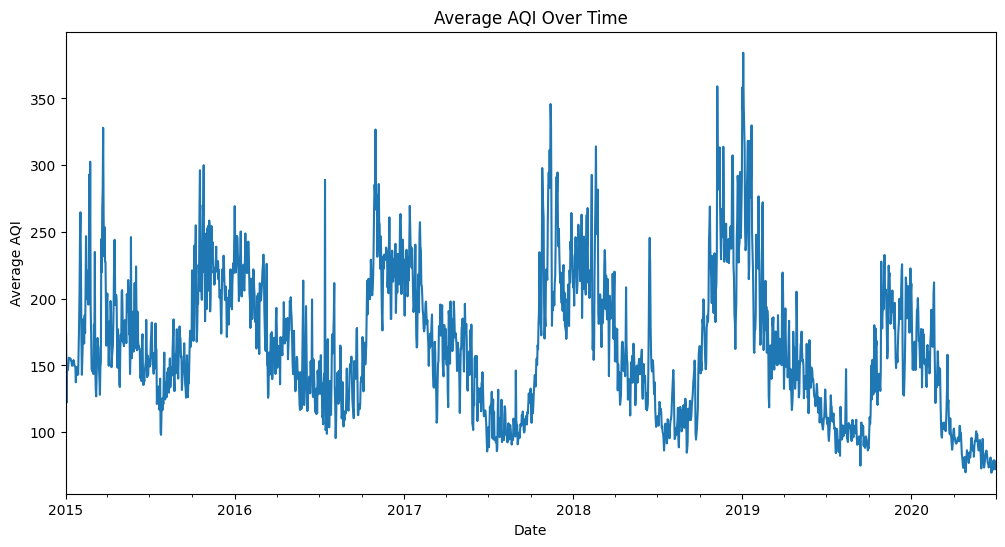

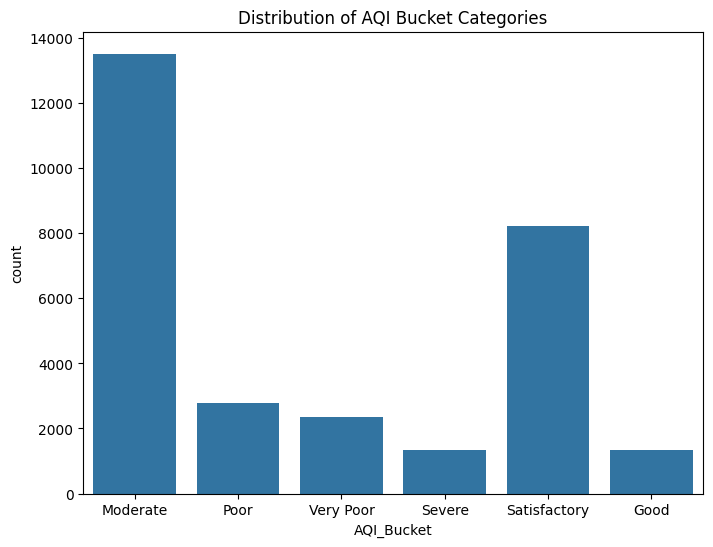

In [ ]:
# EDA Section


# Displaying summary statistics for the dataset
print("Summary Statistics:\n", data.describe())

# Checking for and visualizing correlations among features
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Visualizing distributions of key features
features_to_plot = ['NO', 'AQI']
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Identifying outliers using boxplots for the same key features
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

# Exploring the target variable 'AQI' over time
plt.figure(figsize=(12, 6))
data.groupby('Date')['AQI'].mean().plot()
plt.title('Average AQI Over Time')
plt.ylabel('Average AQI')
plt.xlabel('Date')
plt.show()

# Exploring AQI categories distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='AQI_Bucket', data=data)
plt.title('Distribution of AQI Bucket Categories')
plt.show()





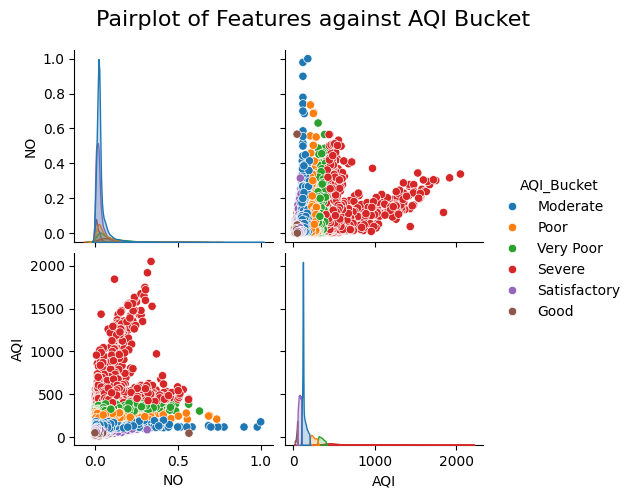

In [ ]:
#Pairplot of Features agaist AQI Bucket
subset_features = ['NO', 'AQI', 'AQI_Bucket']

# Generate the pairplot
pairplot = sns.pairplot(data[subset_features], hue='AQI_Bucket')

# Adjust the title and its position
plt.subplots_adjust(top=0.9)  # This adjusts the top padding of the subplots.
pairplot.fig.suptitle('Pairplot of Features against AQI Bucket', fontsize=16, verticalalignment='top')

# Show the plot
plt.show()
